# Mice sleep
This jupiter notebook should show the implementation described in the project report. 

- The total **execution time** is on a macbook pro 2015 ca. **10min**  


## Python Imports

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifierCV, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from tqdm.notebook import tqdm
from tqdm.keras import TqdmCallback

import helpers
import features
import plots
import models

## Data import
We add directly the artifical features `time`, `day` and `hours` to our dataset. This represents better the fact, that the measurments have been taken each 4 seconds over a timespan of 4 days.

In [5]:
data_folder = 'data/csv/'
file = '10101.smo.csv'

df = features.load_features(data_folder + file)

# adding time features
df = features.add_times(df)

def to_hours(tick):
    return tick / 900.0

df['hours'] = df.index.map(to_hours)

## Data exploration
- [ ] Add bins analysis

### Size of single mouse data set
Each 4 seconds over 4 days a datapoint is taken. This accumulates in a total of 86400 datapoints.

In [6]:
df.shape[0]

86400

### Given features
Where the `rawState` column can have a values `['n', 'r', 'w', 1, 2, 3, 5, 6]` and the `state` column can have the state `['n', 'r', 'w']`

In [7]:
df.head()

,rawState,state,EEGv,EMGv,temp,bin0,bin1,bin2,bin3,bin4,...,bin394,bin395,bin396,bin397,bin398,bin399,bin400,time,day,hours
0,w,w,3.342857e-09,1.083345e-09,0.0,3.912300e-06,1.514550e-06,1.211280e-06,0.000002,0.000002,...,6.094930e-10,8.133010e-10,1.189640e-09,7.768460e-10,9.402300e-10,4.209450e-09,1.345790e-08,0,0,0.000000
1,w,w,3.131613e-09,5.783424e-09,0.0,9.862400e-07,9.839130e-06,2.025640e-05,0.000003,0.000013,...,1.927580e-09,3.126100e-09,2.432780e-09,2.413940e-09,1.469330e-09,6.011740e-09,1.092040e-08,1,0,0.001111
2,w,w,3.202955e-09,1.809422e-09,0.0,9.996850e-06,4.128540e-06,9.773820e-07,0.000022,0.000019,...,6.916030e-10,1.181180e-10,2.069190e-09,2.783830e-09,1.742830e-09,3.697150e-09,7.224770e-09,2,0,0.002222
3,w,w,3.295155e-09,1.861343e-09,0.0,8.497950e-07,3.022740e-07,8.323700e-06,0.000009,0.000003,...,4.721880e-09,4.830450e-09,3.305080e-09,3.367690e-09,2.261620e-09,2.331490e-09,5.494020e-10,3,0,0.003333
4,w,w,3.245190e-09,1.245901e-08,0.0,6.184870e-06,2.382090e-05,1.600790e-05,0.000004,0.000001,...,5.141240e-10,6.648100e-10,5.028890e-10,3.504270e-10,1.121220e-10,5.087680e-09,1.123700e-08,4,0,0.004444


### State
The mouse is either in 'w' = awake, 'n'= rem sleep and 'n' = Not Rem Sleep phase. Depicted below the number of measurements in each state and the relation between `EEGv`, `EMGv` and the state for the first day. 

In [ ]:
print(df.groupby('state').size())

plots.plot_df(data=df, day=0, log=True)


state
n    33955
r     3695
w    48750
dtype: int64


### Distribution of sleep phases over 4 days

Note that the mouse was put under stress in the third and the forth day.

<Figure size 3840x2880 with 0 Axes>

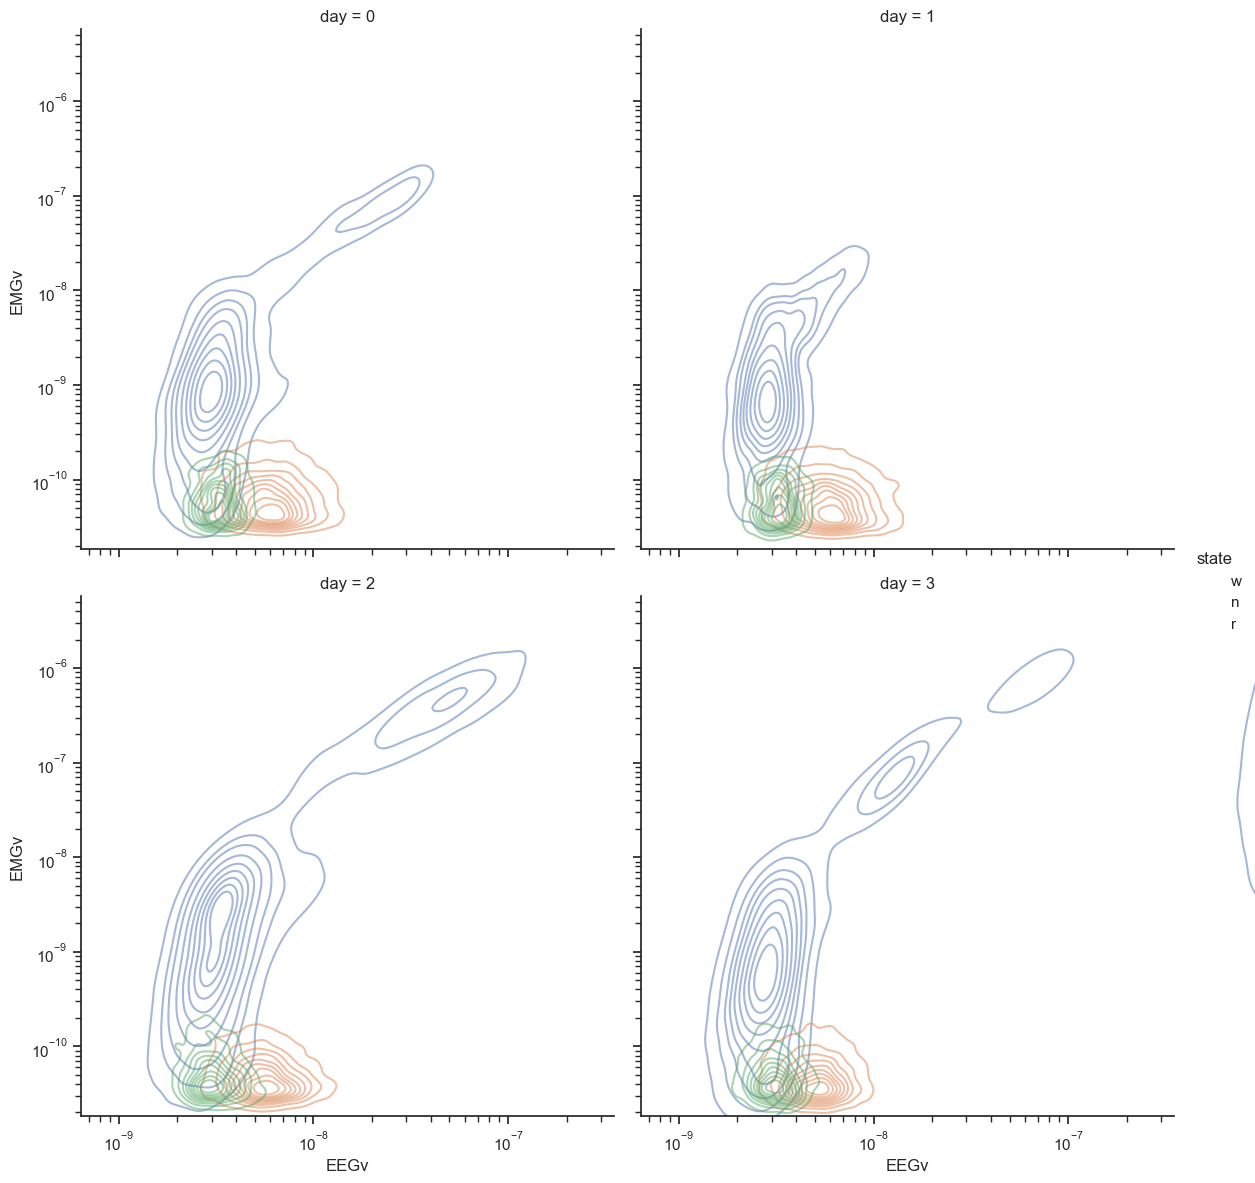

In [ ]:
plots.density(df)

## Feature engineering
- [ ] Check how many spectral roll of we need

### A: Exploiting the EEG frequency spectrum


In [ ]:
# 1) Spectral Flatness Measure
df = features.spectral_flatness(df)

# 2) Sepectral roll-off: 
df = features.spectral_rolloff(df, 0.5)

# 3) Spectral Centroid
df = features.spectral_centroid(df)

# 4) Spectral entropy
df = features.spectral_entropy(df)

# Drop the raw bins
for i in range(401):
        df = df.drop([f"bin{i}"], axis=1)

### B: Adding non-linearity

In [ ]:
df = features.log_features(df, ['EEGv', 'EMGv'])

### C: Aggregating measurements

In [ ]:
df = features.add_mean_variance_feature_windows(df, [10], ['EEGv', 'EMGv'])

### D: Eliminating outliers

In [ ]:
df = features.remove_outliers_quantile(df, ['EEGv', 'EMGv'], threshold=0.95)

### E: Rebalancing

In [ ]:
df = features.rebalance_labels(df)

### F: Normalization and standardization

In [ ]:
# drop unwanted features
df = df.drop(['rawState', "temp"], axis=1)

# Split into train and test set and standardize
x_train, x_test, y_train, y_test, le = features.split_encode_scale_data(df, False, 0.3, 13, True)

## Model fitting


### Neural Network

100%|██████████| 150/150 [00:46<00:00,  3.24epoch/s, loss=0.262, accuracy=0.919, val_loss=0.262, val_accuracy=0.923]


98/98 [==============================] - 0s 914us/step
[[978  54  17]
 [ 60 996  19]
 [ 20  70 906]]
              precision    recall  f1-score   support

           n       0.92      0.93      0.93      1049
           r       0.89      0.93      0.91      1075
           w       0.96      0.91      0.93       996

    accuracy                           0.92      3120
   macro avg       0.93      0.92      0.92      3120
weighted avg       0.92      0.92      0.92      3120



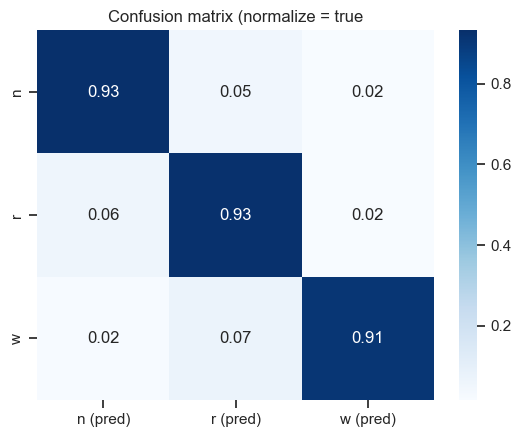

In [ ]:
model = models.nn_baseline_model(x_train.shape[1], le.classes_.size)
# train the model
history = model.fit(x=x_train,
                    y=y_train,
                    validation_data=(x_test, y_test),
                    epochs=150,
                    batch_size=64,
                    verbose=0,
                    callbacks=[TqdmCallback(verbose=1)]
                )

# Plot the confusion matrix
plots.plot_confusion(model=model, x_test=x_test, y_test=y_test, le=le, cat_matrix=True, normalize='true')

### Random forests

In [ ]:
rfc = RandomForestClassifier(random_state=17)
rfc.fit(x_train, y_train)
y_predict = rfc.predict(x_test)

plots.plot_confusion(model=rfc, x_test=x_test, y_test=y_test, le=le, cat_matrix=True, normalize='true')

NameError: name 'x_train' is not defined